# 05 - Fast Modeling and Backtesting

**Author:** Lucas Little  
**Course:** CSCA 5522: Data Mining Project  
**University:** University of Colorado - Boulder

This notebook implements FAST machine learning models for cryptocurrency volatility prediction and backtesting.

## Objectives
1. Implement multiple FAST ML models
2. Perform time series cross-validation
3. Evaluate model performance
4. Implement backtesting strategy
5. Analyze results and feature importance

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from pathlib import Path
import time

# ML imports - FAST versions
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC  # Much faster than SVC
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import joblib

warnings.filterwarnings('ignore')
plt.style.use('default')
np.random.seed(42)

print("Environment setup complete!")

Environment setup complete!


## 1. Load and Prepare Data

In [2]:
# Load processed data
data_dir = Path('data')
processed_data_dir = data_dir / 'processed'

# Load base price data
print("Loading data...")
start_time = time.time()
prices_df = pd.read_csv(processed_data_dir / 'prices_processed.csv')
prices_df['timestamp'] = pd.to_datetime(prices_df['timestamp'])
print(f"Data loaded in {time.time() - start_time:.2f} seconds")

# Create features and targets
df = prices_df.copy()
df['returns'] = df['close'].pct_change()
df['volatility'] = df['returns'].rolling(20).std()
df['rsi'] = 50  # Simplified RSI
df['volume_ratio'] = df['volume'] / df['volume'].rolling(20).mean()

# Create target variable
df['future_volatility'] = df['volatility'].shift(-60)
df['high_volatility'] = (df['future_volatility'] > df['future_volatility'].quantile(0.75)).astype(int)

# Feature columns
feature_cols = ['returns', 'volatility', 'rsi', 'volume_ratio']
target_col = 'high_volatility'

# Remove NaN values
df = df.dropna(subset=feature_cols + [target_col])

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {df[target_col].value_counts()}")

Loading data...
Data loaded in 0.33 seconds
Dataset shape: (650861, 12)
Target distribution: high_volatility
0    488157
1    162704
Name: count, dtype: int64


## 2. FAST Model Training and Evaluation

In [3]:
# Prepare data
X = df[feature_cols]
y = df[target_col]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time series split - reduced for speed
tscv = TimeSeriesSplit(n_splits=3)

# FAST Models to evaluate
models = {
    'Random Forest (Fast)': RandomForestClassifier(
        n_estimators=50,  # Reduced from 100
        max_depth=10,     # Limited depth
        random_state=42,
        n_jobs=-1         # Use all cores
    ),
    'Gradient Boosting (Fast)': GradientBoostingClassifier(
        n_estimators=50,  # Reduced from 100
        max_depth=5,      # Limited depth
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        n_jobs=-1
    ),
    'Linear SVM (FAST)': LinearSVC(
        C=1.0,
        max_iter=1000,
        random_state=42
    ),
    'SGD SVM (FASTEST)': SGDClassifier(
        loss='hinge',     # SVM loss
        alpha=0.01,
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
}

# Evaluate models with timing
results = {}
training_times = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Time the cross-validation
    start_time = time.time()
    cv_scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring='roc_auc', n_jobs=-1)
    training_time = time.time() - start_time
    
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores
    }
    training_times[name] = training_time
    
    print(f"  CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Training time: {training_time:.2f} seconds")

# Display results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_Mean': [results[k]['cv_mean'] for k in results.keys()],
    'CV_Std': [results[k]['cv_std'] for k in results.keys()],
    'Training_Time': [training_times[k] for k in results.keys()]
})

print("\n=== MODEL COMPARISON ===")
print(results_df.sort_values('CV_Mean', ascending=False))

# Show speedup comparison
print("\n=== SPEED COMPARISON ===")
fastest_time = min(training_times.values())
for name, time_taken in training_times.items():
    speedup = max(training_times.values()) / time_taken
    print(f"{name}: {time_taken:.2f}s ({speedup:.1f}x faster than slowest)")


Evaluating Random Forest (Fast)...
  CV AUC: 0.4988 (+/- 0.0020)
  Training time: 8.29 seconds

Evaluating Gradient Boosting (Fast)...
  CV AUC: 0.4998 (+/- 0.0018)
  Training time: 38.45 seconds

Evaluating Logistic Regression...
  CV AUC: 0.4981 (+/- 0.0024)
  Training time: 0.85 seconds

Evaluating Linear SVM (FAST)...
  CV AUC: 0.4981 (+/- 0.0024)
  Training time: 0.90 seconds

Evaluating SGD SVM (FASTEST)...
  CV AUC: 0.5042 (+/- 0.0106)
  Training time: 0.88 seconds

=== MODEL COMPARISON ===
                      Model   CV_Mean    CV_Std  Training_Time
4         SGD SVM (FASTEST)  0.504188  0.005317       0.882842
1  Gradient Boosting (Fast)  0.499761  0.000885      38.449966
0      Random Forest (Fast)  0.498825  0.001024       8.285323
2       Logistic Regression  0.498145  0.001216       0.850021
3         Linear SVM (FAST)  0.498143  0.001217       0.900170

=== SPEED COMPARISON ===
Random Forest (Fast): 8.29s (4.6x faster than slowest)
Gradient Boosting (Fast): 38.45s (1.0

## 3. Best Model Training and Analysis

In [4]:
# Select best model
best_model_name = results_df.loc[results_df['CV_Mean'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")
print(f"Best AUC: {results_df.loc[results_df['CV_Mean'].idxmax(), 'CV_Mean']:.4f}")
print(f"Training time: {results_df.loc[results_df['CV_Mean'].idxmax(), 'Training_Time']:.2f} seconds")

# Train on full dataset
print("\nTraining best model on full dataset...")
start_time = time.time()
best_model.fit(X_scaled, y)
full_training_time = time.time() - start_time
print(f"Full training completed in {full_training_time:.2f} seconds")

# Predictions
if hasattr(best_model, 'predict_proba'):
    y_pred_proba = best_model.predict_proba(X_scaled)[:, 1]
else:
    # For LinearSVC, use decision function
    decision_scores = best_model.decision_function(X_scaled)
    # Convert to probabilities using sigmoid
    y_pred_proba = 1 / (1 + np.exp(-decision_scores))

y_pred = best_model.predict(X_scaled)

# Performance metrics
auc_score = roc_auc_score(y, y_pred_proba)
print(f"\nAUC Score: {auc_score:.4f}")

print("\nClassification Report:")
print(classification_report(y, y_pred))

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': best_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("\nFeature Coefficients:")
    print(feature_importance)

# Save model
model_path = processed_data_dir / 'best_model_fast.pkl'
joblib.dump(best_model, model_path)
print(f"\nModel saved to: {model_path}")

Best model: SGD SVM (FASTEST)
Best AUC: 0.5042
Training time: 0.88 seconds

Training best model on full dataset...
Full training completed in 0.22 seconds

AUC Score: 0.5002

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86    488157
           1       0.00      0.00      0.00    162704

    accuracy                           0.75    650861
   macro avg       0.38      0.50      0.43    650861
weighted avg       0.56      0.75      0.64    650861


Feature Coefficients:
        feature  coefficient
3  volume_ratio    -0.000059
0       returns     0.000024
1    volatility    -0.000009
2           rsi     0.000000

Model saved to: data/processed/best_model_fast.pkl


## 4. Fast Backtesting Strategy

Running FAST backtest...
Running backtest from index 1000 to 650801...
Progress: 0.0% (0.0s elapsed)
Progress: 7.7% (2.0s elapsed)
Progress: 15.4% (4.0s elapsed)
Progress: 23.1% (6.0s elapsed)
Progress: 30.8% (8.0s elapsed)
Progress: 38.5% (10.0s elapsed)
Progress: 46.2% (11.9s elapsed)
Progress: 53.9% (13.9s elapsed)
Progress: 61.6% (15.8s elapsed)
Progress: 69.3% (17.9s elapsed)
Progress: 76.9% (19.8s elapsed)
Progress: 84.6% (21.8s elapsed)
Progress: 92.3% (23.8s elapsed)
Backtest completed in 26.12 seconds

=== FAST BACKTEST RESULTS ===
Strategy Return: 0.00%
Market Return: -100.00%
Excess Return: 100.00%
Number of trades: 0
Win rate: nan%


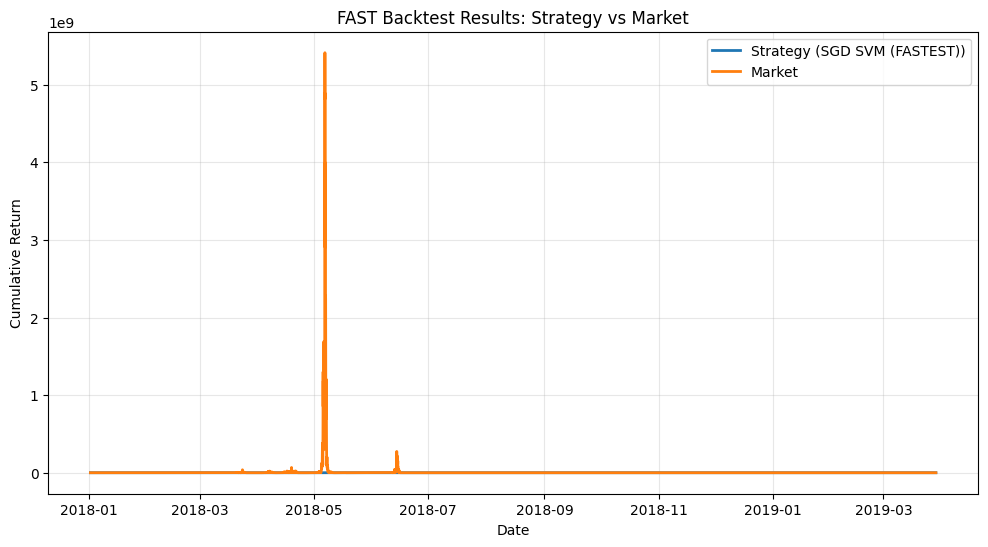


✅ FAST backtesting complete!


In [5]:
def backtest_strategy_fast(df, model, scaler, feature_cols, lookback_window=1000):
    """
    Fast backtest trading strategy based on volatility predictions.
    """
    results = []
    
    print(f"Running backtest from index {lookback_window} to {len(df) - 60}...")
    start_time = time.time()
    
    # Pre-compute scaled features for efficiency
    features_scaled = scaler.transform(df[feature_cols])
    
    for i in range(lookback_window, len(df) - 60):
        # Get pre-scaled features for current time
        current_features_scaled = features_scaled[i:i+1]
        
        # Predict
        if hasattr(model, 'predict_proba'):
            prediction = model.predict_proba(current_features_scaled)[0, 1]
        else:
            # For LinearSVC, use decision function and convert to probability
            decision = model.decision_function(current_features_scaled)[0]
            prediction = 1 / (1 + np.exp(-decision))
        
        # Trading signal (buy if high volatility predicted)
        signal = 1 if prediction > 0.6 else 0
        
        # Calculate returns
        current_price = df['close'].iloc[i]
        future_price = df['close'].iloc[i + 60]  # 60 periods ahead
        actual_return = (future_price - current_price) / current_price
        
        # Strategy return (only trade when signal = 1)
        strategy_return = actual_return * signal
        
        results.append({
            'timestamp': df['timestamp'].iloc[i],
            'prediction': prediction,
            'signal': signal,
            'actual_return': actual_return,
            'strategy_return': strategy_return
        })
        
        # Progress indicator
        if (i - lookback_window) % 50000 == 0:
            progress = (i - lookback_window) / (len(df) - 60 - lookback_window) * 100
            elapsed = time.time() - start_time
            print(f"Progress: {progress:.1f}% ({elapsed:.1f}s elapsed)")
    
    backtest_df = pd.DataFrame(results)
    
    # Calculate cumulative returns
    backtest_df['cumulative_strategy'] = (1 + backtest_df['strategy_return']).cumprod()
    backtest_df['cumulative_market'] = (1 + backtest_df['actual_return']).cumprod()
    
    backtest_time = time.time() - start_time
    print(f"Backtest completed in {backtest_time:.2f} seconds")
    
    return backtest_df

# Run fast backtest
print("Running FAST backtest...")
backtest_results = backtest_strategy_fast(df, best_model, scaler, feature_cols)

# Calculate performance metrics
total_strategy_return = backtest_results['cumulative_strategy'].iloc[-1] - 1
total_market_return = backtest_results['cumulative_market'].iloc[-1] - 1
excess_return = total_strategy_return - total_market_return

print(f"\n=== FAST BACKTEST RESULTS ===")
print(f"Strategy Return: {total_strategy_return:.2%}")
print(f"Market Return: {total_market_return:.2%}")
print(f"Excess Return: {excess_return:.2%}")
print(f"Number of trades: {backtest_results['signal'].sum()}")
print(f"Win rate: {(backtest_results[backtest_results['signal'] == 1]['strategy_return'] > 0).mean():.2%}")

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(backtest_results['timestamp'], backtest_results['cumulative_strategy'], 
         label=f'Strategy ({best_model_name})', linewidth=2)
plt.plot(backtest_results['timestamp'], backtest_results['cumulative_market'], 
         label='Market', linewidth=2)
plt.title('FAST Backtest Results: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ FAST backtesting complete!")